In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'ITC.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,5.550000,5.600000,5.533333,5.583333,3.255736,985500
1996-01-02,5.466666,5.566666,5.288888,5.372222,3.132634,7470000
1996-01-03,5.133333,5.254444,5.101111,5.200000,3.032209,15160500
1996-01-04,5.200000,5.332222,5.144444,5.297777,3.089224,12397500
1996-01-05,5.297777,5.277777,5.188888,5.202222,3.033504,5008500
...,...,...,...,...,...,...
2024-04-25,431.000000,438.299988,429.000000,437.549988,437.549988,29211997
2024-04-26,439.250000,443.299988,436.399994,440.000000,440.000000,14773975
2024-04-29,442.000000,442.450012,434.600006,438.200012,438.200012,11627882


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 18s 14ms/step - loss: 0.0045
Epoch 2/50
221/221 [==============================] - 3s 11ms/step - loss: 0.0014
Epoch 3/50
221/221 [==============================] - 2s 11ms/step - loss: 0.0011
Epoch 4/50
221/221 [==============================] - 2s 11ms/step - loss: 0.0010
Epoch 5/50
221/221 [==============================] - 2s 11ms/step - loss: 9.4263e-04
Epoch 6/50
221/221 [==============================] - 3s 14ms/step - loss: 8.6199e-04
Epoch 7/50
221/221 [==============================] - 2s 11ms/step - loss: 8.5202e-04
Epoch 8/50
221/221 [==============================] - 2s 11ms/step - loss: 7.7190e-04
Epoch 9/50
221/221 [==============================] - 2s 11ms/step - loss: 7.7029e-04
Epoch 10/50
221/221 [==============================] - 2s 11ms/step - loss: 6.7998e-04
Epoch 11/50
221/221 [==============================] - 3s 14ms/step - loss: 7.1892e-04
Epoch 12/50
221/221 [==============================] - 2s 11ms/step

1/1 [==============================] - 0s 20ms/step


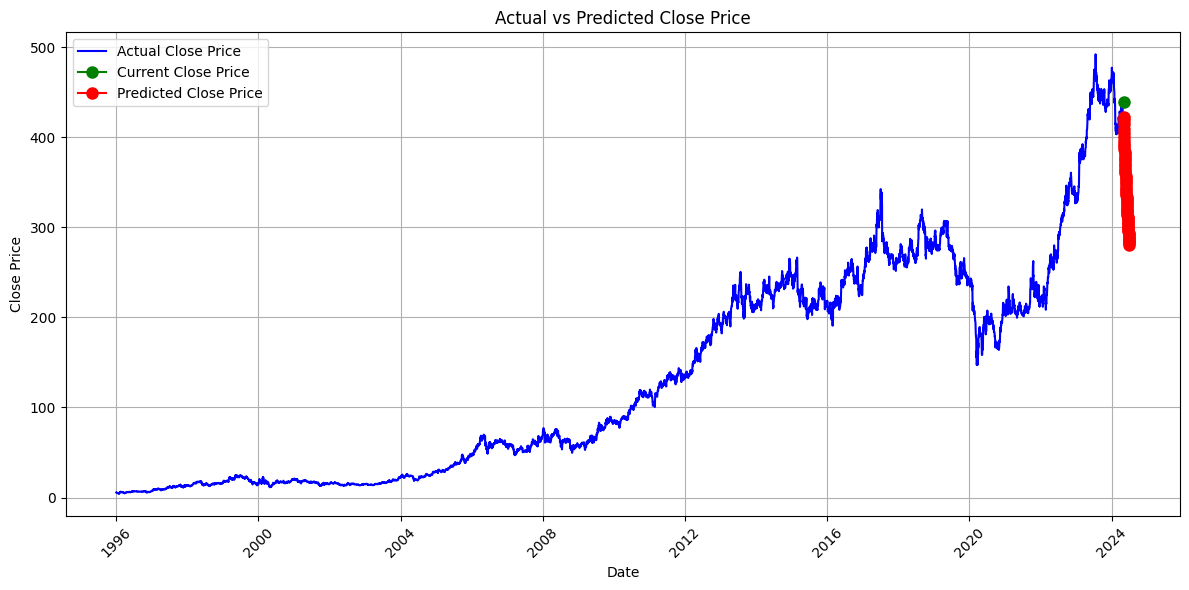

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([422.7185 , 419.35156, 414.47635, 409.30542, 404.4674 , 400.17   ,
       396.3948 , 393.02863, 389.94052, 387.01993, 384.1889 , 381.4009 ,
       378.63373, 375.88092, 373.14487, 370.4315 , 367.74728, 365.09753,
       362.48584, 359.91406, 357.38284, 354.89188, 352.44028, 350.0269 ,
       347.65033, 345.30945, 343.00293, 340.72964, 338.4884 , 336.27826,
       334.09818, 331.94717, 329.82434, 327.7287 , 325.65945, 323.61572,
       321.5967 , 319.6016 , 317.62964, 315.6801 , 313.75235, 311.84558,
       309.9593 , 308.0928 , 306.2455 , 304.4169 , 302.60638, 300.81348,
       299.03763, 297.2784 , 295.53528, 293.80786, 292.09573, 290.39844,
       288.71555, 287.04678, 285.3917 , 283.7499 , 282.12115, 280.50507],
      dtype=float32)

In [10]:
model.save('ITC.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'ITC.pkl')

['ITC.pkl']